In [16]:
import sys

sys.path.insert(0, "..")

import torch 
from functools import partial
import matplotlib.pyplot as plt

from dinov2.data import SamplerType, make_data_loader, make_dataset
from dinov2.data import collate_data_and_cast, DataAugmentationDINO, MaskingGenerator



In [11]:
train_ds_path = "PanMDataset:split=ALL:root=/home/jluesch/Documents/data/pan_m_subset:extra=*"

img_size = 224
patch_size = 14
n_tokens = (img_size // patch_size) ** 2
inputs_dtype = torch.half
do_on_gpu = False
do_data_aug = False

mask_generator = MaskingGenerator(
    input_size=(img_size // patch_size, img_size // patch_size),
    max_num_patches=0.5 * img_size // patch_size * img_size // patch_size,
)

data_transform_cpu = DataAugmentationDINO(
    (0.32, 1.0),
    (0.05, 0.32),
    8,
    global_crops_size=224,
    local_crops_size=96,
    use_kornia=True,
    do_multi_channel=True,
)

# setup data loader
dataset = make_dataset(
    dataset_str=train_ds_path,
    transform=data_transform_cpu,
    target_transform=lambda _: (),
)

print(f"#samples: {len(dataset)}")


Dataset kwargs {'split': <_Split.ALL: 'all'>, 'root': '/home/jluesch/Documents/data/pan_m_subset', 'extra': '*'}
extra_path /home/jluesch/Documents/data/pan_m_subset/*
Datasets imgs file list:  ['/home/jluesch/Documents/data/pan_m_subset/codex_colon/0-TRAIN_images']
Datasets labels file list:  ['/home/jluesch/Documents/data/pan_m_subset/codex_colon/0-TRAIN_labels']
Datasets metadata file list:  ['/home/jluesch/Documents/data/pan_m_subset/codex_colon/0-TRAIN_metadata']
/home/jluesch/Documents/data/pan_m_subset/codex_colon/0-TRAIN_images lmdb_env_imgs.stat() {'psize': 4096, 'depth': 3, 'branch_pages': 27, 'leaf_pages': 1571, 'overflow_pages': 40076, 'entries': 29450}
#samples: 589


In [12]:
sampler_type = SamplerType.SHARDED_INFINITE

collate_fn_cpu = partial(
    collate_data_and_cast,
    mask_ratio_tuple=(0.1, 0.5),
    mask_probability=0.5,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=inputs_dtype,
    do_free_shapes=None,
    use_ch_patch_embed=True,
    use_variable_channels=True,
)

data_loader = make_data_loader(
    dataset=dataset,
    batch_size=4,
    num_workers=8,
    shuffle=True,
    seed=0,
    sampler_type=sampler_type,
    sampler_advance=0,  # TODO(qas): fix this -- start_iter * cfg.train.batch_size_per_gpu,
    drop_last=True,
    collate_fn=collate_fn_cpu,
)

GC [torch.Size([8, 50, 3584, 14])]
LC [torch.Size([32, 50, 96, 96])]


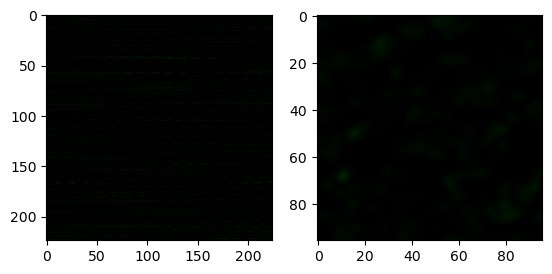

GC [torch.Size([8, 50, 3584, 14])]
LC [torch.Size([32, 50, 96, 96])]


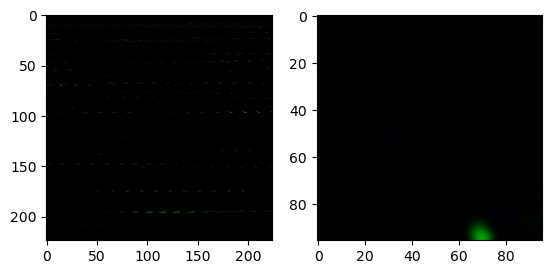

GC [torch.Size([8, 50, 3584, 14])]
LC [torch.Size([32, 50, 96, 96])]


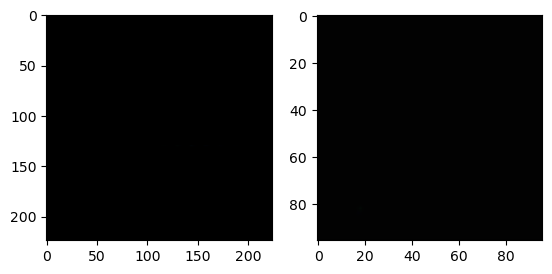

GC [torch.Size([8, 50, 3584, 14])]
LC [torch.Size([32, 50, 96, 96])]


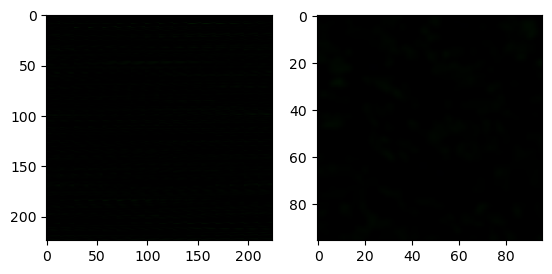

GC [torch.Size([8, 50, 3584, 14])]
LC [torch.Size([32, 50, 96, 96])]


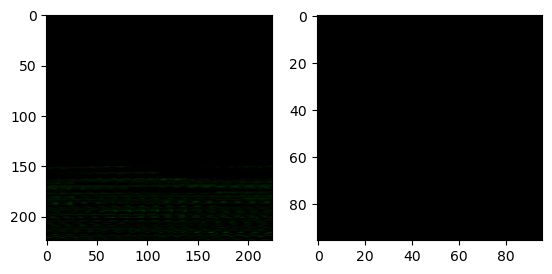

GC [torch.Size([8, 50, 3584, 14])]
LC [torch.Size([32, 50, 96, 96])]


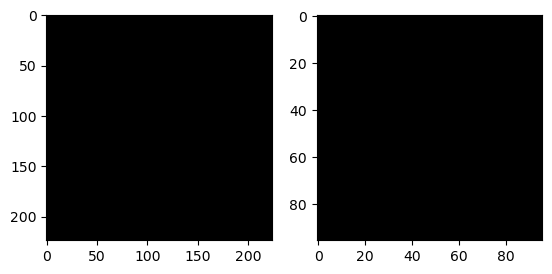

GC [torch.Size([8, 50, 3584, 14])]
LC [torch.Size([32, 50, 96, 96])]


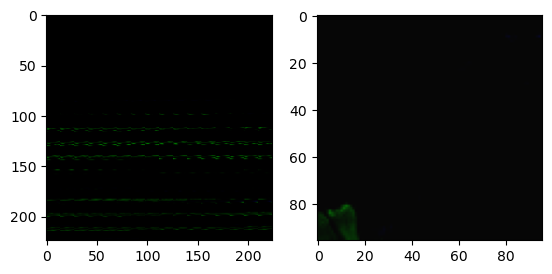

GC [torch.Size([8, 50, 3584, 14])]
LC [torch.Size([32, 50, 96, 96])]


/home/jluesch/micromamba/envs/dinov2_2/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


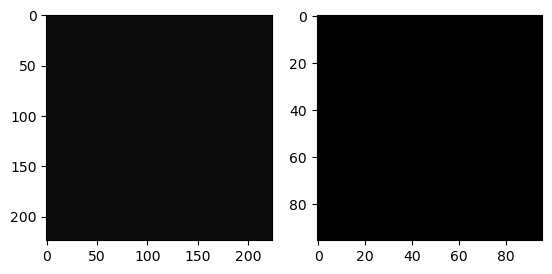

GC [torch.Size([8, 50, 3584, 14])]
LC [torch.Size([32, 50, 96, 96])]


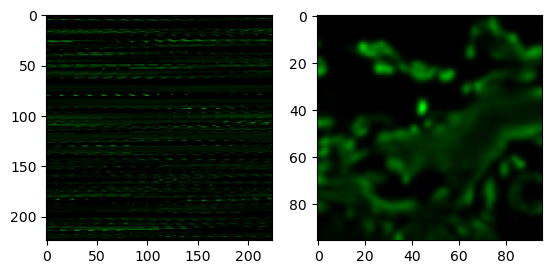

GC [torch.Size([8, 50, 3584, 14])]
LC [torch.Size([32, 50, 96, 96])]


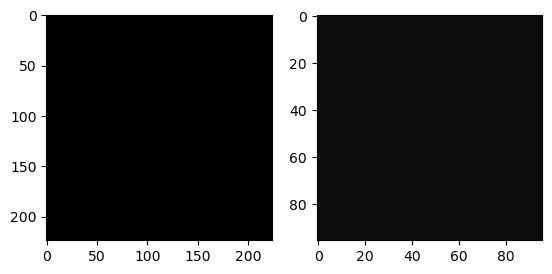

GC [torch.Size([8, 50, 3584, 14])]
LC [torch.Size([32, 50, 96, 96])]


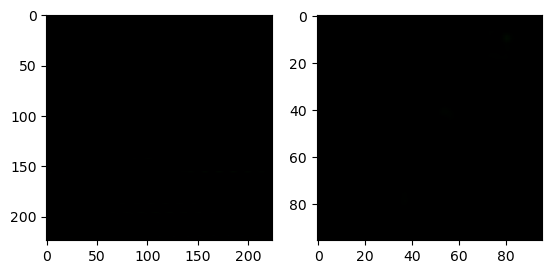

In [30]:
for i, batch in enumerate(data_loader):
    if i > 10:
        break
    print('GC', [e.shape for e in batch['collated_global_crops']])
    print("LC", [e.shape for e in batch["collated_local_crops"]])

    gc_0 = batch['collated_global_crops'][0].to(torch.float32)
    lc_0 = batch["collated_local_crops"][0].to(torch.float32)
    gc0_0 = (gc_0[0] - gc_0[0].min()) / (gc_0[0].max() - gc_0[0].min())
    lc0_0 = (lc_0[0] - lc_0[0].min()) / (lc_0[0].max() - lc_0[0].min())

    f,a = plt.subplots(1, 2)
    a[0].imshow(gc0_0[:3].reshape(3, 224, 224).permute(1, 2, 0))
    a[1].imshow(lc0_0[:3].permute(1, 2, 0))
    plt.show()




In [31]:
a1={'aa': 00, 'bb': 1}

a2={'cc': 2, 'dd': 3}

print(a1 | a2)

{'aa': 0, 'bb': 1, 'cc': 2, 'dd': 3}
